Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

> `![<image title>](http://link.com/to/image.png "image alt text")`

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=250 alt="Project Pythia Logo"></img>

# PaMoDaCo: PMIP4 vs LMR & eVolv2k

---

## Overview
Compare the output of physics-based models to reconstructions from the Last Millennium Reanalysis project and compare to the timing of major volcanic events over the Common Era. 

1. This is a numbered list of the specific topics
1. These should map approximately to your main sections of content
1. Or each second-level, `##`, header in your notebook
1. Keep the size and scope of your notebook in check
1. And be sure to let the reader know up front the important concepts they'll be leaving with

## Prerequisites
This section was inspired by [this template](https://github.com/alan-turing-institute/the-turing-way/blob/master/book/templates/chapter-template/chapter-landing-page.md) of the wonderful [The Turing Way](https://the-turing-way.netlify.app/welcome.html) Jupyter Book.

Following your overview, tell your reader what concepts, packages, or other background information they'll **need** before learning your material. Tie this explicitly with links to other pages here in Foundations or to relevant external resources. Remove this body text, then populate the Markdown table, denoted in this cell with `|` vertical brackets, below, and fill out the information following. In this table, lay out prerequisite concepts by explicitly linking to other Foundations material or external resources, or describe generally helpful concepts.

Label the importance of each concept explicitly as **helpful/necessary**.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from pathlib import Path
import numpy as np
import cftime
import os
from collections import defaultdict
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import pyleoclim as pyleo
from multiprocessing.pool import ThreadPool as Pool
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import intake

## Data-model comparison of GMT over time

### Last Millennium Reanalysis Project (LMR) 

Many methods have been proposed to reconstruct past climates. An increasingly mature and popular framework is that of [paleoclimate data assimilation](https://pastglobalchanges.org/publications/pages-magazines/pages-magazine/7318), which has been applied to many time intervals. In particular, the [Last Millennium Reanalysis](https://cpo.noaa.gov/News/News-Article/ArtMID/6226/ArticleID/1807/Last-Millennium-Reanalysis-now-at-NOAAs-National-Centers-for-Environmental-Information-marking-major-milestone) provides estimates of gridded climate fields like surface air temperature, sea-level pressure, precipitation, and others, together with estimates of their uncertainties (which are often at least as important as the central estimates). 

In a nutshell, LMR blends information from paleoclimate proxies and climate models, with models providing estimates of relationships over space and between variables, while proxies give the timing and amplitude of events. To explore the full distribution of possible trajectories, LMR uses an [ensemble Kalman filter](https://en.wikipedia.org/wiki/Ensemble_Kalman_filter), which employs a Monte Carlo approach to this exploration: each reconstruction starts with a sample of 100 randomly-drawn climate snapshots from a model simulation (each such snapshot is called a _member_). Proxy measurements for each year are used to establish the likelihood of each climate snapshot. In addition, the algorithm conducts 20-50 "iterations", where it selects 75% of the catalog of proxies and reserves the other 25% for validation.
By doing this many times (50 iterations each with different 100 snapshots) we can build a 5000-strong picture of how the climate of the Common Era may have unfolded, capturing uncertainties about this history.

| _For details, see_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |


We'll load datasets using **[Xarray](https://xarray.dev/)**. Xarray is specifically designed to accommodate multidimensional data, like that from a NetCDF file. Let's load 1000 traces of GMST reconstructed using LMR included in Neukom et al. (2019).  

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  Neukom, R., L. A. Barboza, M. P. Erb, F. Shi, J. Emile-Geay, M. N. Evans, J. Franke, D. S. Kaufman, L. Lücke, K. Rehfeld, A. Schurer, F. Zhu, S. Br ̈onnimann, G. J. Hakim, B. J. Henley, F. C. Ljungqvist, N. McKay, V. Valler, and L. von Gunten (2019), Consistent multidecadal variability in global temperature reconstructions and simulations over the common era, Nature Geoscience, 12(8), 643–649, doi:10.1038/s41561-019-0400-0. |


In [2]:
file_path = Path(os.getcwd()).parent.parent/'data/p2k_ngeo19_recons.nc'
p2k_nc = xr.open_dataset(file_path)
p2k_nc

<xarray.Dataset>
Dimensions:  (year: 2000, ens: 1000)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 ... 1994 1995 1996 1997 1998 1999 2000
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Data variables:
    LMRv2.1  (year, ens) float32 ...
    BHM      (year, ens) float64 ...
    DA       (year, ens) float64 ...
    CPS_new  (year, ens) float64 ...
    CPS      (year, ens) float64 ...
    OIE      (year, ens) float64 ...
    PAI      (year, ens) float64 ...
    PCR      (year, ens) float64 ...
    M08      (year, ens) float64 ...

In [3]:
%%time
variable_name = 'LMRv2.1'
ens_grps = p2k_nc.groupby('ens')
traces = []

for im in range(len(p2k_nc.ens)):
    ens_run = ens_grps[im+1].data_vars[variable_name]
    traces.append(pyleo.Series(time=p2k_nc.year, value=ens_run,
                      time_name='Time', time_unit='year',
                      value_name='GMST', value_unit='$^{\circ}$C'))

lmr_ens = pyleo.EnsembleSeries(traces)

CPU times: user 2.25 s, sys: 64.9 ms, total: 2.31 s
Wall time: 2.55 s


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'Default'}, xlabel='Time [year]', ylabel='GMST [$^{\\circ}$C]'>)

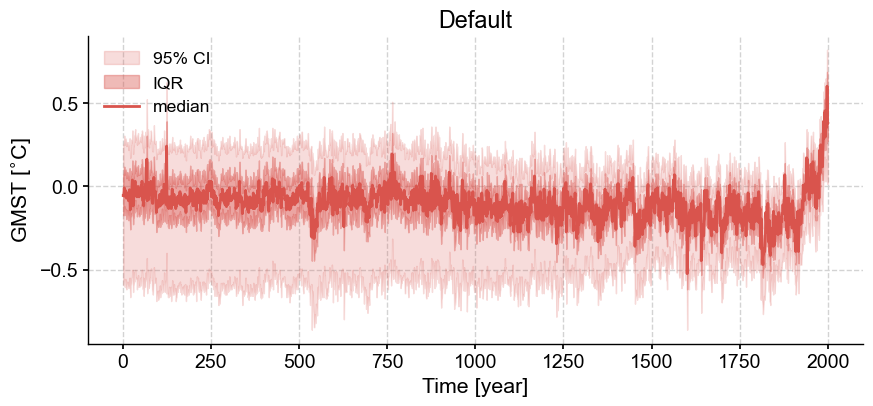

In [4]:
lmr_ens.plot_envelope(title='Default') 

### CMIP6

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|


#### Pulling Data

CMIP6 output constitutes such a large volume of data that no single place hosts the whole collection. A selection of PMIP simulations covering the interval 850 to 1850 are available via Pangeo-Forge, while the much larger swath is hosted by AWS as part of the [AWS Open Data Sponsorship Program](https://aws.amazon.com/opendata/public-datasets/) and Google in [Google Cloud Public Datasets](https://cloud.google.com/public-datasets). In order to look at the interval 850 to present (ish), we'll need both. 

PMIP output for `tas` available via cloud pointer:
- `MIROC-ES2L.past1000.r1i1p1f2.Amon.tas` (Pangeo-Forge)
- `MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas` (Pangeo-Forge, AWS)
- `MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas` (Pangeo-Forge)

CMIP output is available for all three via AWS, so let's tap Pangeo-Forge for PMIP, and AWS for CMIP. 

##### AWS 
To get data from AWS, we will use `intake` to load a json file with information about the AWS holdings, query it, and then pull output of interest. 

In [5]:
# for AWS S3:
col = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")

In [6]:
experiments = ['historical', 'past1000']
sources = ['MIROC-ES2L', 'MRI-ESM2-0', 'MPI-ESM1-2-LR']
variables = ['tas']
members = ['r1i1p1f1', 'r1i1p1f2']

In [7]:
query_d = dict(source_id=sources, 
     experiment_id=experiments, 
     grid_label='gn', 
     variable_id=variables, 
     member_id = members,
     table_id='Amon'
    )

In [8]:
search_res = col.search(**query_d)

In [9]:
_esm_data_d = search_res.to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})
_esm_data_d.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Amon.gn', 'PMIP.MRI.MRI-ESM2-0.past1000.Amon.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn'])

In [10]:
esm_data_d = {}
for key in _esm_data_d.keys():
    parts = key.split('.', 4)
    if parts[1] not in esm_data_d.keys():
        esm_data_d[parts[1]]= defaultdict(dict)
    esm_data_d[parts[1]][parts[2]][parts[3]] = _esm_data_d[key]

##### Pangeo-Forge

In [11]:
PF_cloud_pointers = {'MIROC': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MIROC.MIROC-ES2L.past1000.r1i1p1f2.Amon.tas.gn.v20200318.zarr', 
                     'MRI': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MRI.MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas.gn.v20200120.zarr', 
                     'MPI': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MPI-M.MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas.gn.v20210714.zarr'}

In [12]:
PF_data_d = {key: xr.open_dataset(PF_cloud_pointers[key], engine='zarr', chunks={}, use_cftime=True) for key in PF_cloud_pointers.keys()}


#### Processing data
Data in hand, we need to check that it follows the structure we are expecting, and tune that structure where appropriate. Once we know the data are orderly, we will calculate the global mean annual surface air temperature anomaly relative to the interval 1900-1980, per the approach used for the LMR 2.1 dat loaded above. 

In [13]:

def calc_climatology(ds):
    interval = ds.sel(time=(ds.time.dt.year < 1980) | (ds.time.dt.year >= 1900))
    climatology = interval.groupby("time.month").mean("time")
    return climatology

def remove_seasonality(ds, climatology):
    anomalies = ds.groupby("time.month") - climatology
    return anomalies

def global_mean(ds, lat_weighted=False):
    if lat_weighted is True:
        lat_weights = np.cos(np.deg2rad(ds.lat))
        lat_weights.name = "lat_weights"

        ds_lat_weighted = ds.weighted(lat_weights)
        ds_global_mean = ds_lat_weighted.mean(("lon", "lat"))
    else:
        ds_global_mean = ds.mean(("lon", "lat"))
    return ds_global_mean

def annualize(ds):
    ds_annualized = ds.groupby('time.year').mean('time')
    return ds_annualized


In [14]:
# def calc_anom_lat_wm_annual(climatology, exp):
#     anom_lat_wm_annual_da = annualize(global_mean(remove_seasonality(exp, climatology), lat_weighted=True).compute())
#     anom_lat_wm_annual_ps = pyleo.Series(anom_lat_wm_annual_da.year, anom_lat_wm_annual_da.squeeze(), time_unit='year', 
#                                 clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')#atm temp @2m')
#     return {'da': anom_lat_wm_annual_da, 'ps':anom_lat_wm_annual_ps}

In [15]:
def calc_da_ps(da):
    ps = pyleo.Series(da.year, da.squeeze(), time_unit='year', 
                                clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')#atm temp @2m')
    return {'da': da.squeeze(), 'ps':ps}
    

In [16]:
annualized_anomaly_gwm = {}
annualized_anomaly_spatial = {}

##### MIROC

In [17]:
miroc_model = 'MIROC-ES2L'

In [18]:
_miroc_past1000 = PF_data_d['MIROC']
_miroc_past1000.dims

Frozen({'lat': 64, 'bnds': 2, 'lon': 128, 'time': 12011})

The `time: 12011` is a bit suspicious. Checking for a hiccough never hurts. 

In [19]:
xr.CFTimeIndex(_miroc_past1000.time.data, name=None).is_monotonic_increasing

False

Ah. Finding these wrinkles can tricky. A simple strategy is to group the data by year and check to see if any years have more than 12 entries. 

In [20]:
# group by year
miroc_yeargrps = _miroc_past1000.groupby('time.year').groups

# years with more than 12 entries
miroc_years = [key for key in miroc_yeargrps.keys() if len(miroc_yeargrps[key])>12]
miroc_years

[850]

In [21]:
_miroc_past1000.time[:13].data

array([cftime.Datetime360Day(850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 3, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 5, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 7, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 8, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 10, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 2, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [22]:
_miroc_past1000.time.encoding

{'chunks': (12011,),
 'preferred_chunks': {'time': 12011},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'days since 0850-01-16 00:00:00.000000',
 'calendar': '360_day',
 'dtype': dtype('int64')}

Now we can slice off the initial 11 months and convert the calendar to 'proleptic_gregorian'. 

In [23]:
miroc_past1000 = _miroc_past1000.isel({'time':slice(11,len(_miroc_past1000.time))})#time[:74]
miroc_past1000 = miroc_past1000.convert_calendar('proleptic_gregorian', use_cftime=True, align_on='date')

Now let's convert the calendar of the `historical` output

In [24]:
miroc_hist = esm_data_d['MIROC']['MIROC-ES2L']['historical'].convert_calendar('proleptic_gregorian', use_cftime=True).squeeze()                      

In [25]:
miroc_exp = {'past1000': miroc_past1000['tas'], 'historical': miroc_hist['tas']}

In [26]:
miroc_climatology = calc_climatology(miroc_hist['tas'])

In [27]:
miroc_annualized_anomaly_spatial = {key: annualize(remove_seasonality(miroc_exp[key], miroc_climatology)) for key in miroc_exp.keys()}
annualized_anomaly_spatial['MIROC']=miroc_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [28]:
%%time
miroc_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(miroc_exp[key], miroc_climatology), lat_weighted=True).compute())) for key in miroc_exp.keys()}
for key in miroc_yr_gmt_anom.keys():
    miroc_yr_gmt_anom[key]['ps'].label = '_'.join([miroc_model, key])
    
annualized_anomaly_gwm['MIROC'] = miroc_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 1min 34s, sys: 15.1 s, total: 1min 49s
Wall time: 4min 50s


##### MRI

In [29]:
mri_model = 'MRI-ESM2-0'

In [30]:
mri_past1000 = PF_data_d['MRI']
mri_past1000.time.encoding

{'chunks': (12000,),
 'preferred_chunks': {'time': 12000},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 0850-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [31]:
mri_hist = esm_data_d['MRI']['MRI-ESM2-0']['historical']
mri_hist.time.encoding

{'chunks': (1980,),
 'preferred_chunks': {'time': 1980},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'units': 'days since 1850-01-01',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('float64')}

In [32]:
mri_climatology = calc_climatology(mri_hist['tas'])

In [33]:
mri_exp = {'past1000': mri_past1000['tas'], 'historical': mri_hist['tas']}

In [34]:
%%time
mri_annualized_anomaly_spatial = {key: annualize(remove_seasonality(mri_exp[key], mri_climatology)) for key in mri_exp.keys()}
annualized_anomaly_spatial['MRI']=mri_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 5.65 s, sys: 126 ms, total: 5.77 s
Wall time: 6.06 s


In [35]:
%%time
mri_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(mri_exp[key], mri_climatology), lat_weighted=True).compute())) for key in mri_exp.keys()}
for key in mri_yr_gmt_anom.keys():
    mri_yr_gmt_anom[key]['ps'].label = '_'.join([mri_model, key])
    
annualized_anomaly_gwm['MRI'] = mri_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 1min 6s, sys: 21.7 s, total: 1min 27s
Wall time: 1min 39s


##### MPI

In [36]:
mpi_model = 'MPI-ESM1-2-LR'

In [37]:
mpi_past2k = PF_data_d['MPI']
mpi_past2k.time.encoding

{'chunks': (22200,),
 'preferred_chunks': {'time': 22200},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 7001-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

Wow... `'hours since 7001-01-16 12:00:00.000000'`


If we shift time back 7001 years, the start year becomes 0 and the end year is 1850, consistent with the fact that the MPI-M output is for the past2k, not past1000.

In [38]:
mpi_past2k = mpi_past2k.assign_coords(time=xr.CFTimeIndex(mpi_past2k['time'].values).shift(-7001*12, 'M'))
mpi_past1000 = mpi_past2k.sel(time=(mpi_past2k.time.dt.year >= 850))

In [39]:
mpi_hist = esm_data_d['MPI-M'][mpi_model]['historical']
mpi_hist.time.encoding

{'chunks': (1980,),
 'preferred_chunks': {'time': 1980},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 1850-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [40]:
mpi_climatology = calc_climatology(mpi_hist['tas'])

In [41]:
mpi_exp = {'past1000': mpi_past1000['tas'], 'historical': mpi_hist['tas']}

In [42]:
%%time
mpi_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(mpi_exp[key], mpi_climatology), lat_weighted=True).compute())) for key in mpi_exp.keys()}
for key in mpi_yr_gmt_anom.keys():
    mpi_yr_gmt_anom[key]['ps'].label = '_'.join([mpi_model, key])
    
annualized_anomaly_gwm['MPI'] = mpi_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 43.4 s, sys: 9.63 s, total: 53 s
Wall time: 54.3 s


In [43]:
%%time
mpi_annualized_anomaly_spatial = {key: annualize(remove_seasonality(mpi_exp[key], mpi_climatology)) for key in mpi_exp.keys()}
annualized_anomaly_spatial['MPI']=mpi_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 5.97 s, sys: 145 ms, total: 6.11 s
Wall time: 6.61 s


### Envelope of LMR simulations with CMIP6 output

(850.0, 2014.0)

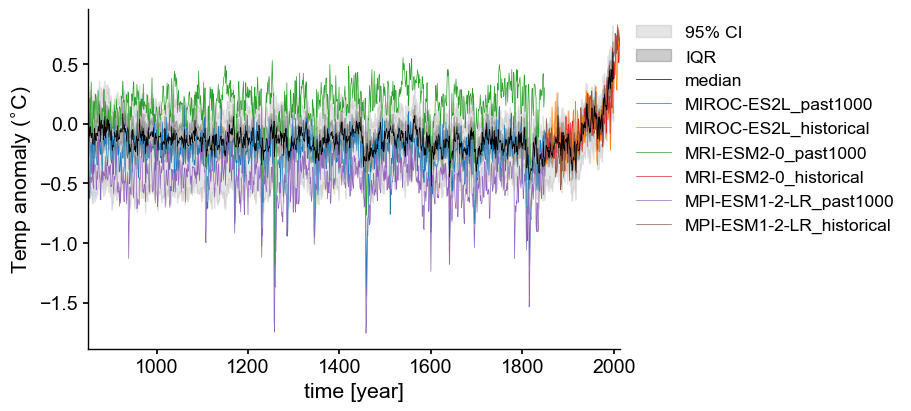

In [46]:
# Create a figure with a gridspec layout to allow us to have two differently sized subplots with a shared x-axis.
fig = plt.figure(figsize=(9, 4), layout="constrained")
spec = fig.add_gridspec(4, 1, hspace=.20)#, sharex=True)

# ax1 = fig.add_subplot(spec[4:, :])
ax2 = fig.add_subplot(spec[:4, :])

# Same EnsembleSeries envelope from above, this time with lines that correspond to volcanic events
lmr_ens.plot_envelope( shade_alpha = .1,  ylabel='GMST [$^{\circ}$C]', 
                                                   curve_lw=.5, shade_clr='k', curve_clr='k', ax=ax2)
for key in annualized_anomaly_gwm.keys():
    for exp in annualized_anomaly_gwm[key].keys():
        annualized_anomaly_gwm[key][exp]['ps'].plot(ax=ax2, linewidth=.5)
    
ax2.xaxis.set_ticks_position('bottom')
# ax2.set_xticklabels([])
# ax2.set_xlabel('')
ax2.grid(False)
ax2.legend(bbox_to_anchor = (1,1))

xlims = [850, 2014]#lmr_ds_ungridded.time.dt.year.min(), lmr_ds_ungridded.time.dt.year.max()]
# ax1.set_xlim(xlims)
ax2.set_xlim(xlims)

## Spatial Visualization
Loading large data files (e.g., compilations, model output), even if only to pull a subset, can be somewhere between challenging and impossible on the average personal computer. Happily, folks at [Pangeo-Forge](https://pangeo-forge.org) have made it their mission to help by developing some infrastructure to make large datasets--often stored in multiple parts--available in clean, consolidated form via a simple URL. Rather than downloading the whole data set, the Pangeo-Forge system allows a user to do tasks like query and subset a data set remotely, only loading data into memory locally by request (for example, to make a plot). 

In [47]:
cmip6_snapshot_ps = {}

### LMR

In [48]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})

In [49]:
lmr_ds_gridded_temp = lmr_ds_gridded['air_mean']

In [50]:
lat = -30
lon = 200
time_pt = 1816

In [51]:
%%time
timeseries = lmr_ds_gridded_temp.sel({'lon': lon, 'lat': lat}, method="nearest")
timeseries = timeseries.chunk({'time':1}).compute()

CPU times: user 25.4 s, sys: 10.5 s, total: 35.9 s
Wall time: 1min 16s


In [52]:
%%time
# this takes about 1.5 minutes
timeseries = lmr_ds_gridded_temp.sel({'lon': lon, 'lat': lat}, method="nearest")
timeseries = timeseries.chunk({'time':1}).compute()

MCrun_grps = [grp for grp in timeseries.groupby('MCrun')]
tmp_pss = []
for MCrun_grp in MCrun_grps:
    MCrun = MCrun_grp[1]
    tmp_pss.append(pyleo.Series(MCrun.time.dt.year, MCrun.data, time_unit='year', clean_ts=False, value_name='MCrun {}'.format(MCrun_grp[0])))


CPU times: user 24.9 s, sys: 10.4 s, total: 35.3 s
Wall time: 1min 7s


In [53]:
surftemp_mean = timeseries.mean(dim='MCrun').compute()

In [54]:
lmr_ds_gridded_temp_mean = lmr_ds_gridded_temp.mean(dim='MCrun')

In [55]:
snapshot_data = lmr_ds_gridded_temp_mean.sel(time=(lmr_ds_gridded_temp_mean.time.dt.year == time_pt))

In [56]:
cmip6_snapshot_ps['LMR2.1'] = {'snapshot':snapshot_data, 'ps_atloc':{'full':pyleo.Series(surftemp_mean.time.dt.year, surftemp_mean.data, label='LMR2.1', time_unit='year', clean_ts=False)}}

### CMIP6

In [59]:
%%time
# this may take ~5 minutes
for key in annualized_anomaly_spatial.keys():
    # spatial at time_pt
    snapshot_anom = annualized_anomaly_spatial[key]['past1000'].sel({'year':time_pt}).squeeze()
    # time series in location
    exp_d = {}
    for exp in annualized_anomaly_spatial[key].keys():
        ts_atloc = annualized_anomaly_spatial[key][exp].sel({'lon': lon, 'lat': lat}, method="nearest").chunk({'year':len(annualized_anomaly_spatial[key][exp].year)}).squeeze().compute()
        ps_atloc = pyleo.Series(ts_atloc.year, ts_atloc.data, time_unit='year', clean_ts=False, label= '_'.join([key, exp]))
        exp_d[exp] = ps_atloc
    cmip6_snapshot_ps[key]= {'snapshot':snapshot_anom, 'ps_atloc':exp_d}


CPU times: user 2min 32s, sys: 43.2 s, total: 3min 15s
Wall time: 5min 52s


### Combined figure

In [60]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if n is None:
        ax_cmap = plt.get_cmap(cmap)
    else:    
        ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [61]:
lims = [np.abs(cmip6_snapshot_ps[key]['snapshot'].max().compute()) for key in cmip6_snapshot_ps.keys()]
lims += [np.abs(cmip6_snapshot_ps[key]['snapshot'].min().compute()) for key in cmip6_snapshot_ps.keys()]

# establish scale
ax2_Li_1 = max(lims)
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}


Text(0, 0.5, 'GMT (°C)')

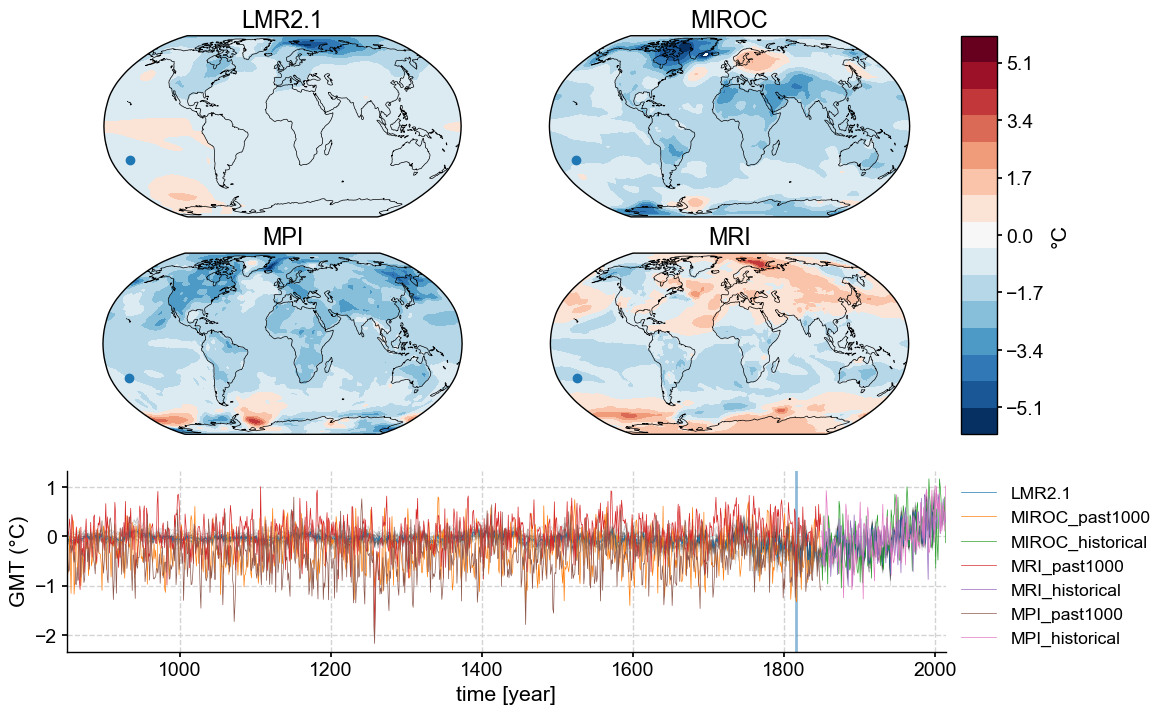

In [69]:
nc = 21
fig = plt.figure(figsize=(12, 8))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(3, 3, wspace=0.05, hspace=.2,width_ratios=[3,3,.25], height_ratios=[3,3,3])

# add subplot with specified map projection and coastlines (GeoAxes)
gs_squares = [gs[0, 0], gs[0, 1], gs[1, 0], gs[1, 1]]
axs = [fig.add_subplot(sqr, projection=ccrs.Robinson(central_longitude=0)) for sqr in gs_squares]

for ik, key in enumerate(['LMR2.1', 'MIROC', 'MPI', 'MRI']):#cmip6_snapshot_ps.keys()):
    axs[ik].add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)
    # place data on coordinate system with continuous x axis (longitude axis)
    tas_c, lonc = cutil.add_cyclic_point(cmip6_snapshot_ps[key]['snapshot'], cmip6_snapshot_ps[key]['snapshot']['lon'])
    # plot contourf on ax2 (geosubplot)
    cf2 = axs[ik].contourf(lonc,cmip6_snapshot_ps[key]['snapshot']['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                       transform=ccrs.PlateCarree(), **cf2_kwargs)
    axs[ik].scatter(lon, lat, transform=ccrs.PlateCarree())
    axs[ik].set_title(key)

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[:2, 2])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label="\xb0C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     

# time series
ax_ts = fig.add_subplot(gs[2, :2])
ax_ts.axvline(x=time_pt, alpha=.5)
# MCruns = [ik for ik in range(2)]
for MCrun_ps in tmp_pss:
    # mcrun_ts = timeseries.sel({'MCrun':MCrun})
    MCrun_ps.plot(ax=ax_ts, color='k', alpha=.15, linewidth=.5)
    # ax1.plot(mcrun_ts.time.dt.year, mcrun_ts.data, label = str(MCrun), alpha=.5)

# CMIP6 trajectories
for key in cmip6_snapshot_ps.keys():
    for exp in cmip6_snapshot_ps[key]['ps_atloc'].keys():
        cmip6_snapshot_ps[key]['ps_atloc'][exp].plot(ax=ax_ts, linewidth=.5)
        
ax_ts.legend(bbox_to_anchor=(1,1))
ax_ts.set_xlim([850, 2014])
ax_ts.set_ylabel('Annualized TAS anomaly (\xb0C)')

CPU times: user 629 ms, sys: 38.2 ms, total: 667 ms
Wall time: 1.28 s


Text(0, 0.5, 'GMT (°C)')

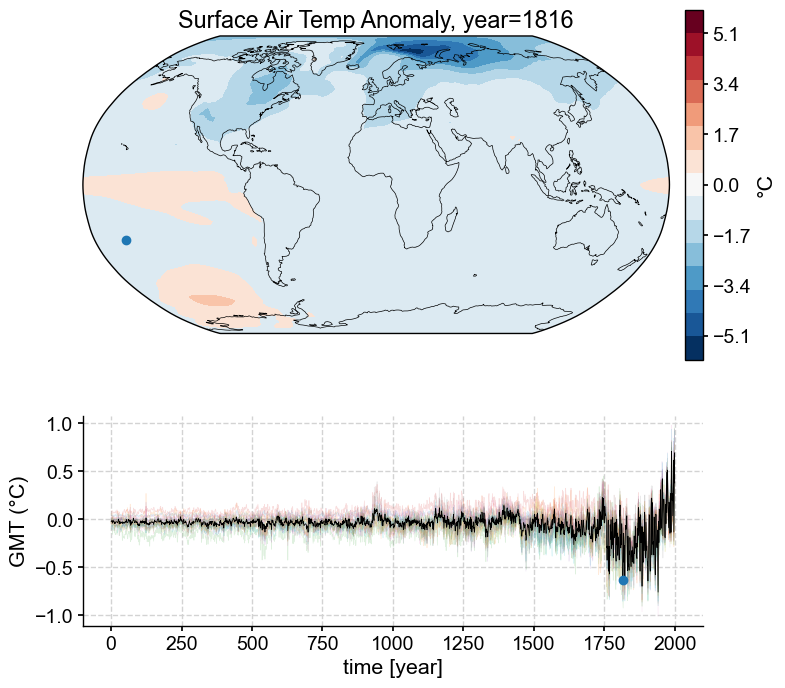

In [63]:
%%time
nc = 21
fig = plt.figure(figsize=(8, 8))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(2, 2, wspace=0.05, width_ratios=[8, .25], height_ratios=[5,3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# establish scale
ax2_Li_1 = max([np.abs(snapshot_data.max().compute()), 
                np.abs(snapshot_data.min().compute())])
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(snapshot_data, snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,snapshot_data['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                   transform=ccrs.PlateCarree(), **cf2_kwargs)
ax2.scatter(lon, lat, transform=ccrs.PlateCarree())

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label="\xb0C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     
ax2.set_title('Surface Air Temp Anomaly, year={}'.format(time_pt))

ax1 = fig.add_subplot(gs[1, 0:])
# MCruns = [ik for ik in range(2)]
for MCrun_ps in tmp_pss:
    # mcrun_ts = timeseries.sel({'MCrun':MCrun})
    MCrun_ps.plot(ax=ax1, alpha=.15, linewidth=.5)
    # ax1.plot(mcrun_ts.time.dt.year, mcrun_ts.data, label = str(MCrun), alpha=.5)

ax1.plot(surftemp_mean.time.dt.year, surftemp_mean, label = 'Surface Temp mean', alpha=1, color='k', linewidth=.5)
ax1.scatter([time_pt], surftemp_mean.sel(time=(surftemp_mean.time.dt.year == time_pt)).data, zorder=10)
ax1.set_ylabel('GMT (\xb0C)')

### Subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax (demo below from link),

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**Jupyter docs**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) for Jupyter-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

If you're comfortable, and as we briefly used for our embedded logo up top, you can embed raw html into Jupyter Markdown cells (edit to see):

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!